# School staffing level analysis

I want to compare staffing levels per student in each school district to state grant funding levels to try and determine the sensitivity of districts to state cuts. I'll adjust grants to their proportion of each district's budget, since districts vary greatly in what portion of their budget comes from the state. In wealthy districts, it's usually a very small portion of their education budget, while in poor cities, it can be the vast majority.

#### Data sources

I need the following data at the district level

* Education spending - Municipal Fiscal Indicators
* Enrollment - Edsight and Municipal Fiscal Indicators (I will use the latter since it will save me a join)
* Staffing FTEs - Edsight
* State grant funding - ???


### ./data files

Here's what's in the data folder

In [1]:
ls "data/EDSIGHT_STAFFING/"

FTEStaffing (1).csv   FTEStaffing (15).csv  FTEStaffing (6).csv
FTEStaffing (10).csv  FTEStaffing (16).csv  FTEStaffing (7).csv
FTEStaffing (11).csv  FTEStaffing (2).csv   FTEStaffing (8).csv
FTEStaffing (12).csv  FTEStaffing (3).csv   FTEStaffing (9).csv
FTEStaffing (13).csv  FTEStaffing (4).csv   FTEStaffing.csv
FTEStaffing (14).csv  FTEStaffing (5).csv


In [2]:
ls "data/FISCAL_INDICATORS/"

FISCIN12.csv      FISCIN14.csv      FISCIN16.csv
FISCIN13.csv      FISCIN15.csv      FI_2007-2012.csv


In [3]:
import pandas as pd

In [4]:
class EdsightReport(object):
    
    def fix_equals(self, col):
        self.df[col] = self.df[col].str.strip("=").str.strip("\"")
    
    def __init__(self, fname):
        self.fname = fname
        self.report_name = open(self.fname).readline().strip().strip("\"")
        self.df = pd.read_csv(self.fname,skiprows=2)

        


In [5]:
class SchoolOrganizations(EdsightReport):
    
    def __init__(self, *args, **kwargs):
        super(SchoolOrganizations, self).__init__("data/findSchoolDistrict.csv", *args, **kwargs)
        self.fix_equals("OrganizationCode")
        self.fix_equals("ZIP")
        for grade_column in ["Grade " + str(x) for x in range(1, 13)]:
            self.fix_equals(grade_column)
            
class Districts(SchoolOrganizations):
    
    def find_by_city(self, city):
        return self.df[self.df["City"].str.upper().str.contains(city.upper())][["OrganizationName","OrganizationType"]]
    
    def find_by_name(self, name):
        return self.df[self.df["OrganizationName"].str.upper() == name.upper()]
    
    def __init__(self, *args, **kwargs):
        super(Districts, self).__init__()
        self.df = self.df[self.df["OrganizationType"].str.contains("District")]
        
    
districts = Districts()
print districts.report_name
districts.df["OrganizationType"].value_counts()
print districts.find_by_city("Bridgeport")

Find School/District Results
                                     OrganizationName  \
719                        Bridgeport School District   
807   Capital Preparatory Harbor School Inc. District   
1135               Great Oaks Charter School District   
1493       New Beginnings Inc Family Academy District   
1730           Park City Prep Charter School District   
2057                      The Bridge Academy District   

                     OrganizationType  
719           Public School Districts  
807   Public Charter School Districts  
1135  Public Charter School Districts  
1493  Public Charter School Districts  
1730  Public Charter School Districts  
2057  Public Charter School Districts  


In [6]:
class StaffingReport(EdsightReport):
    
    def __init__(self, *args, **kwargs):
        super(StaffingReport, self).__init__(*args, **kwargs)
        self.year = self.report_name.replace("FTE Staffing Report for ", "")
        self.fiscal_year = self.year[:2] + self.year[-2:]
        self.df["District"] = self.df["District"].fillna(method="ffill")
        self.fix_equals("District")
        self.fix_equals("Assignment Category")
        self.fix_equals("Educator Type")
        self.df = self.df.set_index(["District","Assignment Category","Educator Type"])
        self.df["report_year"] = self.fiscal_year
        self.df = self.df.reset_index().set_index("District").join(districts.df.set_index("OrganizationName")[["City","OrganizationCode","OrganizationType"]])

er = StaffingReport("data/EDSIGHT_STAFFING/FTEStaffing (1).csv")
print er.report_name
print er.year
print er.fiscal_year
er.df.head()


FTE Staffing Report for 2002-03
2002-03
2003


,Assignment Category,Educator Type,FTE Count,report_year,City,OrganizationCode,OrganizationType
Amistad Academy District,Administrators Coordinators and Department Ch...,Certified,1.8,2003,New Haven,2790013,Public Charter School Districts
Amistad Academy District,Counselors Social Workers and School Psychol...,Certified,1.0,2003,New Haven,2790013,Public Charter School Districts
Amistad Academy District,General Education - Teachers and Instructors,Certified,14.9,2003,New Haven,2790013,Public Charter School Districts
Amistad Academy District,General Education - Paraprofessional Instructi...,Non-Certified,3.0,2003,New Haven,2790013,Public Charter School Districts
Amistad Academy District,Library/Media - Support Staff,Non-Certified,0.0,2003,New Haven,2790013,Public Charter School Districts


In [38]:
# See how many categories are empty
check_empties = pd.pivot_table(er.df.reset_index(),
                   index=["index","report_year"],
                   values="FTE Count",
                   columns="Assignment Category")
check_empties.head()

,Assignment Category,Administrators Coordinators and Department Chairs - District Central Office,Administrators Coordinators and Department Chairs - School Level,Counselors Social Workers and School Psychologists,General Education - Paraprofessional Instructional Assistants,General Education - Teachers and Instructors,Instructional Specialists Who Support Teachers,Library/Media - Specialists (Certified),Library/Media - Support Staff,Other Staff Providing Non-Instructional Services/Support,School Nurses,Special Education - Paraprofessional Instructional Assistants,Special Education - Teachers and Instructors
index,report_year,,,,,,,,,,,,
Amistad Academy District,2003,NaN,1.8,1.0,3.0,14.9,NaN,NaN,0.0,4.4,0.0,0.0,1.0
Andover School District,2003,0.6,1.4,NaN,6.3,23.6,2.0,1.0,0.1,15.8,1.0,7.4,3.0
Ansonia School District,2003,3.0,7.2,9.0,24.1,136.8,3.0,1.0,5.0,89.6,4.0,13.5,18.0
Area Cooperative Educational Services,2003,8.0,15.2,24.6,8.8,131.0,10.8,2.0,0.0,59.9,3.4,2.6,90.4
Ashford School District,2003,0.8,2.0,1.0,2.0,37.0,1.6,NaN,1.0,25.7,1.2,11.0,6.0


In [39]:
print len(check_empties)
print len(check_empties.dropna(how="any"))

192
151


In [7]:
print "These are districts that can't be reconciled to a city"
set(er.df[er.df["City"].isnull()].index.tolist())

These are districts that can't be reconciled to a city


{'Highville Mustard Seed Charter School District',
 'Office of Early Childhood (OEC)',
 'Project Oceanology',
 'Unified School District #1',
 'Unified School District #2'}

In [8]:
# Now pull in all the school stuff
import os

def all_staffing_years():
    frames = []
    years = []

    for f in os.listdir("data/EDSIGHT_STAFFING/"):
        fpath = os.path.join("data/EDSIGHT_STAFFING/",f)
        report = StaffingReport(fpath)
        #print (report.fiscal_year)
        if int(report.fiscal_year) in years:
            raise Exception("Duplicate year: " + str(report.fiscal_year))
        years.append(int(report.fiscal_year))
        new_df = report.df.reset_index()
        new_df["report_year"] = new_df["report_year"].astype(int)
        new_df = new_df.set_index(["report_year","index","Assignment Category","Educator Type"])
        frames.append(new_df)
    years.sort()
    print years
    return pd.concat(frames)

staffing_df = all_staffing_years()
staffing_df.head()

[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


FTE Count  \
report_year index                    Assignment Category                                Educator Type              
2003        Amistad Academy District Administrators  Coordinators and Department Cha... Certified            1.8   
                                     Counselors  Social Workers  and School Psycholo... Certified            1.0   
                                     General Education - Teachers and Instructors       Certified           14.9   
                                     General Education - Paraprofessional Instructio... Non-Certified        3.0   
                                     Library/Media - Support Staff                      Non-Certified        0.0   

                                                                                                            City  \
report_year index                    Assignment Category                                Educator Type              
2003        Amistad Academy District Administrators  Coordinators and Department Cha... Certified      New Haven   
                                     Counselors  Social Workers  and School Psycholo... Certified      New Haven   
                                     General Education - Teachers and Instructors       Certified      New Haven   
                                     General Education - Paraprofessional Instructio... Non-Certified  New Haven   
                                     Library/Media - Support Staff                      Non-Certified  New Haven   

                                                                                                      OrganizationCode  \
report_year index                    Assignment Category                                Educator Type                    
2003        Amistad Academy District Administrators  Coordinators and Department Cha... Certified              2790013   
                                     Counselors  Social Workers  and School Psycholo... Certified              2790013   
                                     General Education - Teachers and Instructors       Certified              2790013   
                                     General Education - Paraprofessional Instructio... Non-Certified          2790013   
                                     Library/Media - Support Staff                      Non-Certified          2790013   

                                                                                                                      OrganizationType  
report_year index                    Assignment Category                                Educator Type                                   
2003        Amistad Academy District Administrators  Coordinators and Department Cha... Certified      Public Charter School Districts  
                                     Counselors  Social Workers  and School Psycholo... Certified      Public Charter School Districts  
                                     General Education - Teachers and Instructors       Certified      Public Charter School Districts  
                                     General Education - Paraprofessional Instructio... Non-Certified  Public Charter School Districts  
                                     Library/Media - Support Staff                      Non-Certified  Public Charter School Districts

In [9]:
import re 
class FiscalIndicators(object):
    
    def __init__(self, fname):
        self.fname = fname
        self.df = pd.read_csv(self.fname)
        match = re.match("FISCIN([0-9]*).csv",os.path.basename(self.fname))
        if match:
            self.df["Fisc_Year_End"] = int(2000 + int(str(match.group(1)).zfill(2)))
        else:
            pass
        
        
fi = FiscalIndicators("data/FISCAL_INDICATORS/FISCIN12.csv")
fi.df.head()

,Municipality,numbered,Comptroller Town Code,County_Identifier,Invested In Capital Assets Net of Related Debt,Unrestricted Net Assets,Total Net Assets,Change In Net Assets,Nonspendable_Fund_Bal,Restricted_Fund_Bal,...,Overal_Total_Tax_Collection_Rate,2012 Population,Moody's_Bond_Ratings_July2012,ACGLFY12,EGL,TANF12 Recipients,empl,ACMR,enrollmt,Fisc_Year_End
0,HARWINTON,67.0,66.0,L,16750121.0,3827597.0,20874093.0,-591809.0,0.0,0.0,...,0.978598,5600.0,NaN,5.539185e+08,7.481629e+08,8.0,0.065630,23.90,914.82,2012
1,HEBRON,68.0,67.0,T,49016212.0,5215082.0,54540996.0,1255942.0,0.0,0.0,...,0.967581,9624.0,Aa2,8.682188e+08,1.115239e+09,8.0,0.058585,30.26,2080.81,2012
2,KENT,69.0,68.0,L,9539728.0,4337856.0,13934963.0,249895.0,0.0,0.0,...,0.966632,2951.0,Aa2,6.600050e+08,8.102808e+08,6.0,0.063482,14.27,339.37,2012
3,KILLINGLY,70.0,69.0,W,97765533.0,17963381.0,116355514.0,-486136.0,0.0,0.0,...,0.962143,17269.0,Aa2,1.311451e+09,1.626788e+09,191.0,0.104180,19.20,2549.12,2012
4,KILLINGWORTH,71.0,70.0,M,24630446.0,5352114.0,29982560.0,-528247.0,0.0,0.0,...,0.990374,6504.0,Aa2,8.182932e+08,1.010341e+09,6.0,0.058010,22.77,1067.30,2012


In [10]:
def all_fiscal_indicators():
    frames = []
    cols = ["Municipality","Education","enrollmt","Fisc_Year_End"]
    for fname in os.listdir("data/FISCAL_INDICATORS/"):
        if not fname.lower().endswith("csv"): continue
        fpath = os.path.join("data/FISCAL_INDICATORS/",fname)
        fi = FiscalIndicators(fpath)            
        fi.df["SOURCE"] = fname
        
        if "fiscin" not in fname.lower():
            # Drop 2012
            fi.df = fi.df[fi.df["Fisc_Year_End"] != 2012]

        frames.append(fi.df[cols])
    return pd.concat(frames)
all_fiscal_indicators()["Fisc_Year_End"].value_counts()

2016    170
2015    170
2014    170
2013    170
2012    170
2011    170
2010    170
2009    170
2008    170
2007    170
Name: Fisc_Year_End, dtype: int64

In [11]:
fiscal_df = all_fiscal_indicators()
fiscal_df.columns = ["City","Education spending","Enrollment","report_year"]
fiscal_df = fiscal_df.set_index(["City","report_year"])


In [12]:
staffing_df["City"] = staffing_df["City"].str.upper()
staffing_with_fiscal_df = staffing_df.reset_index().set_index(["City","report_year"]).merge(fiscal_df,on=["City","report_year"])
staffing_with_fiscal_df.head()

index  \
City      report_year                                                     
NEW HAVEN 2009         Achievement First Hartford Academy Inc. District   
          2009         Achievement First Hartford Academy Inc. District   
          2009         Achievement First Hartford Academy Inc. District   
          2009         Achievement First Hartford Academy Inc. District   
          2009         Achievement First Hartford Academy Inc. District   

                                                     Assignment Category  \
City      report_year                                                      
NEW HAVEN 2009         Administrators  Coordinators and Department Ch...   
          2009              General Education - Teachers and Instructors   
          2009         General Education - Paraprofessional Instructi...   
          2009                             Library/Media - Support Staff   
          2009                                             School Nurses   

                       Educator Type  FTE Count OrganizationCode  \
City      report_year                                              
NEW HAVEN 2009             Certified        6.0          2880013   
          2009             Certified       20.0          2880013   
          2009         Non-Certified        0.0          2880013   
          2009         Non-Certified        0.0          2880013   
          2009         Non-Certified        0.5          2880013   

                                      OrganizationType  Education spending  \
City      report_year                                                        
NEW HAVEN 2009         Public Charter School Districts         192024547.0   
          2009         Public Charter School Districts         192024547.0   
          2009         Public Charter School Districts         192024547.0   
          2009         Public Charter School Districts         192024547.0   
          2009         Public Charter School Districts         192024547.0   

                       Enrollment  
City      report_year              
NEW HAVEN 2009           18074.31  
          2009           18074.31  
          2009           18074.31  
          2009           18074.31  
          2009           18074.31

In [27]:
staffing_with_fiscal_df.to_csv("output/staffing-with-fiscal.csv")


In [13]:
public_df = staffing_with_fiscal_df[staffing_with_fiscal_df["OrganizationType"] == "Public School Districts"]
public_df.head()

index  \
City      report_year                              
NEW HAVEN 2009         New Haven School District   
          2009         New Haven School District   
          2009         New Haven School District   
          2009         New Haven School District   
          2009         New Haven School District   

                                                     Assignment Category  \
City      report_year                                                      
NEW HAVEN 2009         Administrators  Coordinators and Department Ch...   
          2009              General Education - Teachers and Instructors   
          2009         General Education - Paraprofessional Instructi...   
          2009                             Library/Media - Support Staff   
          2009                                             School Nurses   

                       Educator Type  FTE Count OrganizationCode  \
City      report_year                                              
NEW HAVEN 2009             Certified      115.2          0930011   
          2009             Certified     1284.2          0930011   
          2009         Non-Certified      236.0          0930011   
          2009         Non-Certified        1.0          0930011   
          2009         Non-Certified       30.3          0930011   

                              OrganizationType  Education spending  Enrollment  
City      report_year                                                           
NEW HAVEN 2009         Public School Districts         192024547.0    18074.31  
          2009         Public School Districts         192024547.0    18074.31  
          2009         Public School Districts         192024547.0    18074.31  
          2009         Public School Districts         192024547.0    18074.31  
          2009         Public School Districts         192024547.0    18074.31

In [14]:
#timeline
pd.pivot_table(public_df.groupby(["City","report_year"]).agg({"Education spending":sum}).reset_index(),
               values="Education spending",
               index="City",
               columns="report_year").head()

report_year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
City,,,,,,,,,,
ANDOVER,82587604.0,97119539.0,88625416.0,86290391.0,88108438.0,92494611.0,94191548.0,96807469.0,94344899.0,87804550.0
ANSONIA,355931160.0,461016120.0,378251904.0,387392964.0,382750140.0,405177216.0,409496544.0,429417984.0,444358008.0,462095724.0
ASHFORD,109681011.0,117166660.0,108167180.0,108851660.0,110695500.0,110847770.0,112503090.0,117585590.0,129491813.0,118255900.0
AVON,467592480.0,655741080.0,530553708.0,541735392.0,563732712.0,615507468.0,640761168.0,679592196.0,697776732.0,713818620.0
BARKHAMSTED,93207228.0,98947167.0,100456536.0,101577912.0,102152964.0,103175976.0,106225284.0,112357440.0,103756389.0,104532659.0


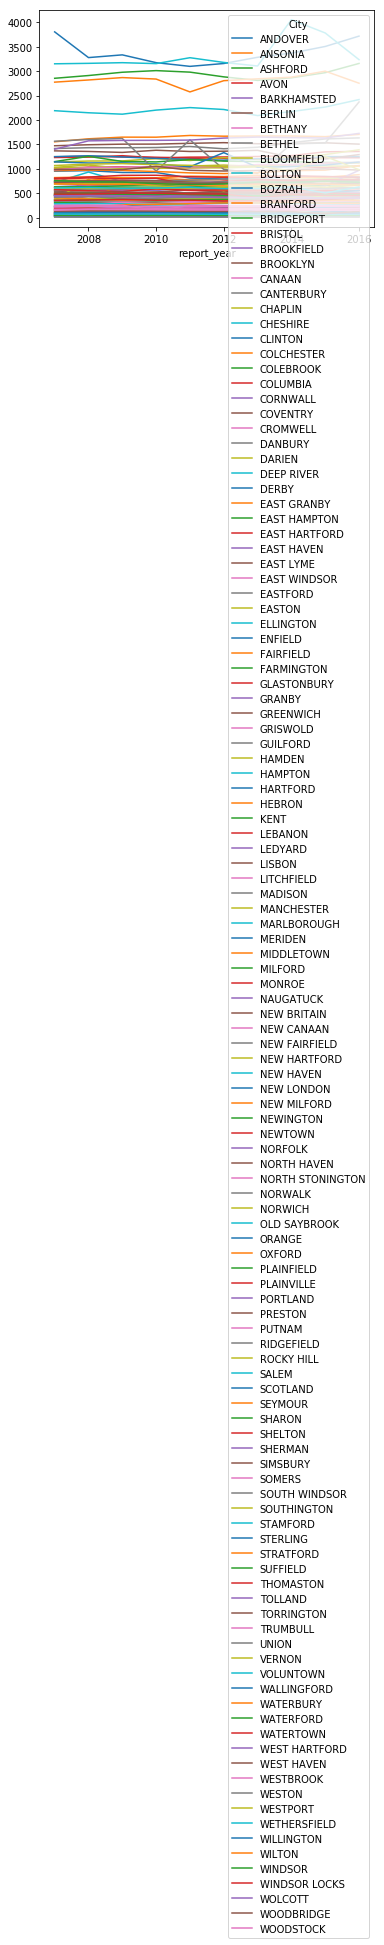

In [15]:
%matplotlib inline
pd.pivot_table(public_df.groupby(["City","report_year"]).agg({"FTE Count":sum}).reset_index(),
               values="FTE Count",
               index="City",
               columns="report_year").transpose().plot()

In [16]:
def timetable(col="FTE Count",adjust=False):
    
    ret = public_df.reset_index()
    report_years = set(ret["report_year"].tolist())
    min_y = min(report_years)

    ret = pd.pivot_table(
        ret.groupby(["City","report_year"]).agg({col:sum}).reset_index(),
        index="City",
        columns="report_year",
        values=col)
    
    if adjust:
        for c in report_years:
            base_vals = ret[min_y].astype(float).copy()
            if c == min_y:continue
            ret[c] = ret[c].astype(float) / base_vals
        ret[min_y] = 1.
    return ret
timetable("FTE Count",adjust=True).head()

report_year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
City,,,,,,,,,,
ANDOVER,1.0,0.952381,0.975369,0.985222,0.980296,0.945813,0.929392,0.929392,0.855501,0.891626
ANSONIA,1.0,0.800122,0.825847,0.761944,0.815843,0.795427,0.769089,0.799714,0.708861,0.721723
ASHFORD,1.0,1.020234,1.033014,1.037274,1.024494,1.030884,0.984026,0.974441,1.020234,1.031949
AVON,1.0,1.015264,1.105102,1.087658,1.125164,1.162233,1.149804,1.107501,1.113171,1.110554
BARKHAMSTED,1.0,1.007181,1.005386,0.974865,1.041293,0.987433,0.962298,0.965889,1.000000,1.050269


In [17]:
def timetable_town(town, col="FTE Count", adjust=False):
    df = timetable(col=col, adjust=adjust)
    return df.loc[town]

timetable_town("BRIDGEPORT").to_frame().reset_index()


,report_year,BRIDGEPORT
0,2007,2854.1
1,2008,2910.5
2,2009,2977.8
3,2010,3011.3
4,2011,2980.2
5,2012,2883.5
6,2013,2811.1
7,2014,2864.0
8,2015,2969.0
9,2016,3157.9


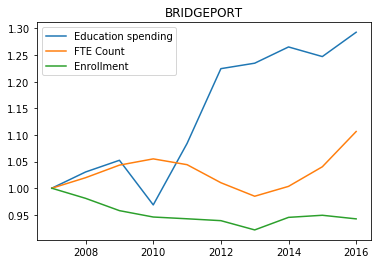

In [18]:
import matplotlib.pyplot as plt
def plot_town(town, cols=["FTE Count"],ax=None,adjust=False):
#     df = public_df.reset_index()
#     df = df[df["City"] == town]
#     min_y = min(set(df["report_year"].tolist()))
#     base_val = df[df["report_year"] == min_y][col]
   
#     df = df.groupby(["City","report_year"]).agg({col:sum}).reset_index()
    fig, ax = plt.subplots()
    for col in cols:
        df = timetable_town(town,col=col,adjust=adjust)
        ax.plot(df, label=col)
        #ax.legend([col])
        ax.set_title(town)
        ax.legend()
        

plot_town("BRIDGEPORT",cols=["Education spending","FTE Count","Enrollment"],adjust=True)

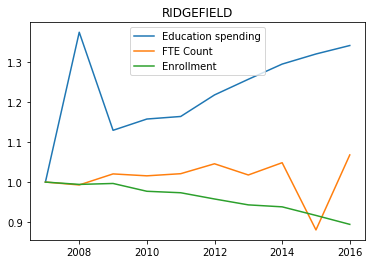

In [19]:
plot_town("RIDGEFIELD",cols=["Education spending","FTE Count","Enrollment"],adjust=True)

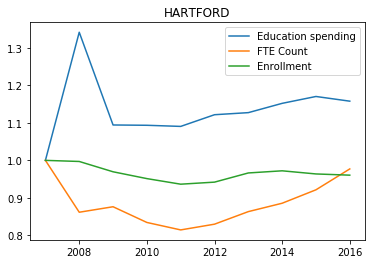

In [20]:
plot_town("HARTFORD",cols=["Education spending","FTE Count","Enrollment"],adjust=True)

In [21]:
public_df.corr()

,FTE Count,Education spending,Enrollment
FTE Count,1.000000,0.434035,0.445329
Education spending,0.434035,1.000000,0.966257
Enrollment,0.445329,0.966257,1.000000


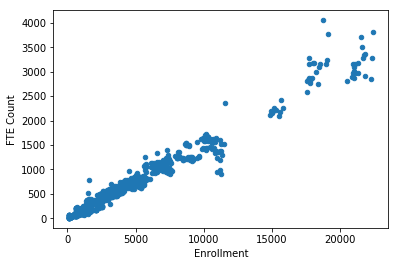

In [22]:
public_df.groupby(["City","report_year"]).agg({"FTE Count":sum,
                                               "Education spending":max,
                                               "Enrollment":max}).plot.scatter(x="Enrollment",y="FTE Count")

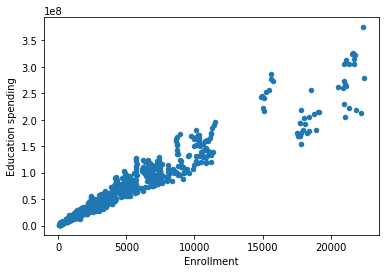

In [23]:
public_df.groupby(["City","report_year"]).agg({"FTE Count":sum,
                                               "Education spending":max,
                                               "Enrollment":max}).plot.scatter(x="Enrollment",y="Education spending")

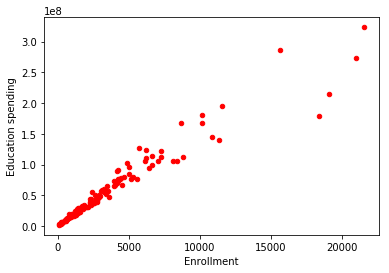

In [24]:

def label_scatter(x="Enrollment",y="Education spending",thresh=15000,year=2016):
    fig, ax = plt.subplots()
    df = public_df.groupby(["City","report_year"]).agg({"FTE Count":sum,
                                                   "Education spending":max,
                                                   "Enrollment":max})
    df = df.reset_index()

    #df = df[df["Enrollment"] > 15000]
    df = df[df["report_year"] == year]
    
    colors = ["red","green","blue","yellow","orange","purple","gray","gold"]
    color_i = -1
    for tmp_year in set(df["report_year"].tolist()):
        color_i += 1
        tmpdf_df = df[df["report_year"] == tmp_year]

        tmpdf_df.plot(x=x,y=y, kind='scatter', ax=ax, color=colors[color_i%len(colors)])

#         for i, row in df.reset_index().iterrows():
#             if row[x] < thresh: continue
#             ax.annotate(row["City"], (row[x],row[y]))
        
label_scatter(thresh=15000)

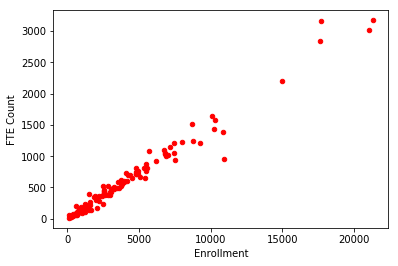

In [25]:
label_scatter(x="Enrollment",y="FTE Count",year=2010)